# ASAXS data reduction

Author: Eike Gericke

This is a script to treat experimental small-angle scattering data. The script reads the input file created using the script >pyASAXS_InputFileGenerator<. The input file (inputFile) sould contain all nessesary information for the data reduction and the identifiers for the scattering pattern files (.tif or .edf format). \
\
In the "Data Input" part the correct header names from the input file must be adressed to the variables like "sampleName" and "monitorDiode". If the diodes for X-ray beam intensity monitoring measured in avaraging mode, the acquisition time must be used. If the X-ray beam intensity monitoring measured in integrating mode, the acquisition time must be set to 1 in the input file. \
\
The most nessesary python libraries can be installed ba pip install ... \
fabio is for image processing \
pyFAI is for azimuthal integration specialized for SAXS and WAXS from the ESRF. \
If opencl libraries are installed and pyopencl is working the pyFAI modueles should run in parallel on CPU and on GPU. If not one CPU core will do the job. 

## Libraries

In [1]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M

## Coror Fuction

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Data Input

In [5]:
# give the data directory
data_dir = 'files\Data_for_ASAXS'
# give the input file
inputFile = 'Data_for_ASAXS_ASCII_out_changed_13082020.txt'
# give the reference file location. The Reference file must be a 1D scattering curve 
# in absolute scattering cross section units of the measured reference sample.
pathTo_ReferenceFile = 'files\GC-Calibration_Final\GC-K_54um-c.dat'

# Information for the azimuthal integration from 2D scattering images to 1D scattering curves
bin_number = 400 #how many data points are generated in the 1D curves
pixelsize = 172e-6 # in meter
scale = 1  # upscaling of poisson error only for visibility in plotting. Not used for the exported data.

# Write the corrected scattering images? A lot of export data will be produced!
write_the_images = False # only if True images are written to the target directory

#read the input file
path_to_inputFile = data_dir + os.sep + inputFile
inputFrame = pd.read_csv(path_to_inputFile, sep='\t',index_col=0)

# Define divice identifiers
sampleName = 'SampleName'
imageNumber = 'Pilatus_Tiff'
imageName = 'Pilatus_filename'
monitorDiode = 'Keysight4'
monitorDeviation = 'Keysight4:StandardDeviation'
transmissionDiode = 'Keysight1'
transmissionDeviation = 'Keysight1:StandardDeviation'
acquisitionTime = 'PilatusAcqTime'
sampleThickness = 'SampleThickness'
sampleName = 'SampleName'
xray_energy = 'Energy'
maskFileName = 'MaskFile'
BackGround_SubtractionFactor = 'BackGround_SubtractionFactor'
x_Center_String = 'x_Center' # in pixel
y_Center_String = 'y_Center' # in pixel
sampleToDetectorDistance = 'SampleToDet_Distance' # in meter
emptyIndex = 'Empty_Index' # the index number given targets the empty beam measurement to use
BackGrIndex = 'Background_Index' # the index number given targets the scattering background measurement to use
referenceIndex = 'Reference_Index' # the index number given targets the reference measurement tu use

[]

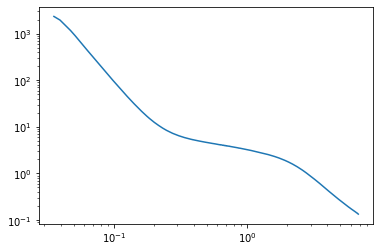

In [6]:
# Test the reference file and plot it
refData = np.genfromtxt(pathTo_ReferenceFile, delimiter=',',comments='#')
ref0_q = np.empty(0)
ref0_I = np.empty(0)
ref0_e = np.empty(0)
for i in range(refData.shape[0]):
    ref0_q = np.append(ref0_q,refData[i][0])
    ref0_I = np.append(ref0_I,refData[i][1])
    ref0_e = np.append(ref0_e,refData[i][2])
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.loglog()

## Data Handling

  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


Directory  files\Data_for_ASAXS\Corrected_1D  already exists
Directory  files\Data_for_ASAXS\Corrected_2D  already exists
x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00379.tif | Empty is: pilatus_2020kw29tg14_00378.tif
Reference Normalization between: 0.2578379350531872 nm^-1 and  1.150917351632831 nm^-1
Index for Reference file: 56 with 0.2565 nm^-1 to 259 with 1.1473 nm^-1
Index for Experimental Reference data: 9 with 0.25581372972142585 nm^-1 to 72 with 1.1440770650852516 nm^-1
known 3.705720409 experimental 2710522891.0195727 factor 1.3671607132622592e-09


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00397.tif | Empty is: pilatus_2020kw29tg14_00396.tif
Reference Normalization between: 0.294818960590897 nm^-1 and  1.3159904346770253 nm^-1
Index for Reference file: 66 with 0.29596 nm^-1 to 268 with 1.3138 nm^-1
Index for Experimental Reference data: 9 with 0.29250442825987744 nm^-1 to 72 with 1.3081690640108796 nm^-1
known 3.8955079114999993 experimental 3765216625.6563244 factor 1.034603928219127e-09


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00415.tif | Empty is: pilatus_2020kw29tg14_00414.tif
Reference Normalization between: 0.30347459445502356 nm^-1 and  1.3546268080079695 nm^-1
Index for Reference file: 68 with 0.30385 nm^-1 to 270 with 1.3508 nm^-1
Index for Experimental Reference data: 9 with 0.30109211097515853 nm^-1 to 72 with 1.3465758072086855 nm^-1
known 3.9438948710000004 experimental 4058021934.161238 factor 9.718761837632041e-10


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00433.tif | Empty is: pilatus_2020kw29tg14_00432.tif
Reference Normalization between: 0.30586880575624054 nm^-1 and  1.3653138474925939 nm^-1
Index for Reference file: 69 with 0.30779 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental Reference data: 9 with 0.3034675194477034 nm^-1 to 72 with 1.3571993354347853 nm^-1
known 3.967947962 experimental 4124873038.7938337 factor 9.619563862165027e-10


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00451.tif | Empty is: pilatus_2020kw29tg14_00450.tif
Reference Normalization between: 0.306605475446321 nm^-1 and  1.3686022845610886 nm^-1
Index for Reference file: 69 with 0.30779 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental Reference data: 9 with 0.3041984223490766 nm^-1 to 72 with 1.3604682147304894 nm^-1
known 3.967947962 experimental 4160964990.7574635 factor 9.536124362530802e-10


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00469.tif | Empty is: pilatus_2020kw29tg14_00468.tif
Reference Normalization between: 0.30682666170696454 nm^-1 and  1.3693399999999993 nm^-1
Index for Reference file: 69 with 0.30779 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental Reference data: 9 with 0.30441786759812867 nm^-1 to 72 with 1.3614496248106533 nm^-1
known 3.967947962 experimental 4152244498.571498 factor 9.556152012158963e-10


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00487.tif | Empty is: pilatus_2020kw29tg14_00486.tif
Reference Normalization between: 0.330511842345719 nm^-1 and  1.3693399999999993 nm^-1
Index for Reference file: 75 with 0.33147 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental Reference data: 9 with 0.32791709708238315 nm^-1 to 67 with 1.3761780084993134 nm^-1
known 3.8208709039999995 experimental 4645564911.030299 factor 8.224771318828912e-10


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)
  File "<ipython-input-5-c4e35b15fc90>", line 153, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00505.tif | Empty is: pilatus_2020kw29tg14_00504.tif
Reference Normalization between: 0.3683394534903624 nm^-1 and  1.3693399999999993 nm^-1
Index for Reference file: 86 with 0.36699 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental Reference data: 9 with 0.36544773030230315 nm^-1 to 59 with 1.372547750064092 nm^-1
known 3.6163762915 experimental 5192636922.93914 factor 6.964431261358162e-10


<ipython-input-5-c4e35b15fc90>:223: RuntimeWarning: invalid value encountered in true_divide
  e = I * (e/I + image_transmission_deviation/image_transmission)


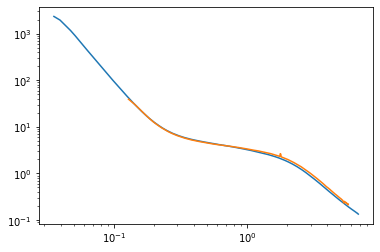

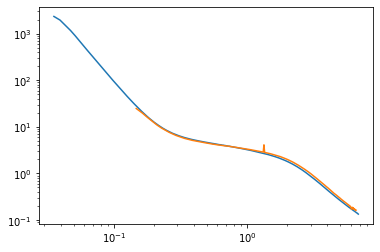

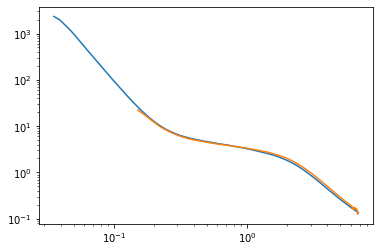

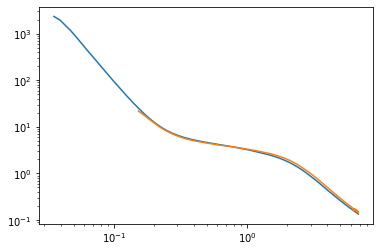

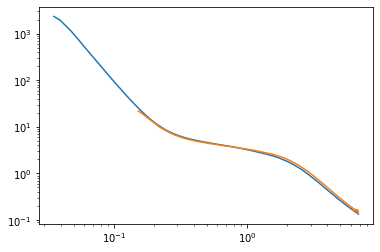

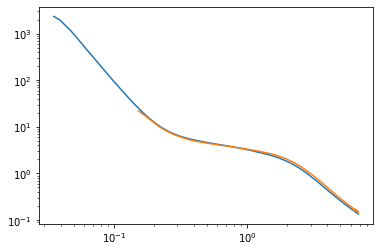

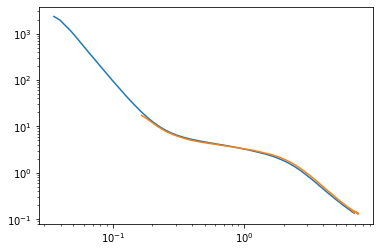

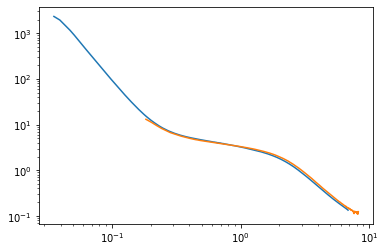

In [5]:
# Variabables which are needed and redefined during the data processing below
usedBackGr_index = 'False'
usedReference_index = 'False'
x_Center_old = 'False'
y_Center_old = 'False'
energy_old = 'False'
stDetDist_old = 'False'
maskFile_old = 'False'
correctionFrame = pd.DataFrame()

#Create Output Directories
#Output directories will be created if they not jet exist
pathSave_to1D = data_dir + os.sep + 'Corrected_1D'
pathSave_to2D = data_dir + os.sep + 'Corrected_2D'

if not os.path.exists(pathSave_to1D):
    os.mkdir(pathSave_to1D)
    print("Directory " , pathSave_to1D ,  " Created ")
else:    
    print("Directory " , pathSave_to1D ,  " already exists")

if not os.path.exists(pathSave_to2D):
    os.mkdir(pathSave_to2D)
    print("Directory " , pathSave_to2D ,  " Created ")
else:    
    print("Directory " , pathSave_to2D ,  " already exists")

# Data processing    
    
for element in inputFrame.index:
    # read the image
    tiffName = inputFrame[imageName][element].split('/')[-1]
    tiffPath = data_dir + os.sep + tiffName
    image_object = fabio.open(tiffPath)
    image = image_object.data
    
    # read values
    name = inputFrame[sampleName][element]
    monitorI = inputFrame[monitorDiode][element]
    transmI = inputFrame[transmissionDiode][element]
    monitorI_dev = inputFrame[monitorDeviation][element]
    transmI_dev = inputFrame[transmissionDeviation][element]
    acqTime = inputFrame[acquisitionTime][element]
    thickness = inputFrame[sampleThickness][element]
    energy = inputFrame[xray_energy][element]
    tifNum = inputFrame[imageNumber][element]
    BackGr_SubstF = inputFrame[BackGround_SubtractionFactor][element]
    
    empty_monitorI = inputFrame[monitorDiode][inputFrame[emptyIndex][element]]
    empty_transmI = inputFrame[transmissionDiode][inputFrame[emptyIndex][element]]
    
    # calculate transmission
    image_transmission = (transmI/monitorI)/(empty_transmI/empty_monitorI)
    image_transmission_deviation = image_transmission * (monitorI_dev/monitorI + transmI_dev/transmI)
    #print(tiffName,'measured',acqTime,'sec with transmission:' , image_transmission, '+/-',image_transmission_deviation)
    
    # normalizing image
    image = image / monitorI / acqTime / image_transmission
    
    # loead the image background file
    if int(inputFrame[BackGrIndex][element]) == usedBackGr_index:
        #print('stay')
        pass
    else:
        # read the BackGround image
        tiffName_BackGr = inputFrame[imageName][inputFrame[BackGrIndex][element]].split('/')[-1]
        tiffPath_BackGr = data_dir + os.sep + tiffName_BackGr
        image_object_BackGr = fabio.open(tiffPath_BackGr)
        image_BackGr = image_object_BackGr.data
        usedBackGr_index = int(inputFrame[BackGrIndex][element])
        
        # read BackGround values
        monitorI_BG = inputFrame[monitorDiode][usedBackGr_index]
        transmI_BG = inputFrame[transmissionDiode][usedBackGr_index]
        monitorI_BG_dev = inputFrame[monitorDeviation][usedBackGr_index]
        transmI_BG_dev = inputFrame[transmissionDeviation][usedBackGr_index]
        acqTime_BG = inputFrame[acquisitionTime][usedBackGr_index]
        empty_monitorI_BG = inputFrame[monitorDiode][inputFrame[emptyIndex][usedBackGr_index]]
        empty_transmI_BG = inputFrame[transmissionDiode][inputFrame[emptyIndex][usedBackGr_index]]
        
        # calculate BackGround transmission
        image_transmission_BG = (transmI_BG/monitorI_BG)/(empty_transmI_BG/empty_monitorI_BG)
        image_transmission_BG_deviation = image_transmission_BG * (monitorI_BG_dev/monitorI_BG + transmI_BG_dev/transmI_BG)
        
        # normalizing BackGround image
        image_BackGr = image_BackGr / monitorI_BG / acqTime_BG / image_transmission_BG
        #print(usedBackGr_index,'=',image_transmission_BG,'+/-',image_transmission_BG_deviation)
    
    # Subtract the scattering Background
    image = image - image_BackGr*BackGr_SubstF
    image = image/thickness
    
    # loead the image Reference file
    if int(inputFrame[referenceIndex][element]) == usedReference_index:
        #print('stay')
        pass
    else:
        usedReference_index = int(inputFrame[referenceIndex][element])
        # read the Reference image
        tiffName_Ref = inputFrame[imageName][usedReference_index].split('/')[-1]
        tiffPath_Ref = data_dir + os.sep + tiffName_Ref
        image_object_Ref = fabio.open(tiffPath_Ref)
        image_Ref = image_object_Ref.data
        
        tiffName_Empty = inputFrame[imageName][inputFrame[emptyIndex][usedReference_index]].split('/')[-1]
        tiffPath_Empty = data_dir + os.sep + tiffName_Ref
        image_object_Empty = fabio.open(tiffPath_Empty)
        image_Empty = image_object_Empty.data
        
        
        # read Reference values
        monitorI_Ref = inputFrame[monitorDiode][usedReference_index]
        transmI_Ref = inputFrame[transmissionDiode][usedReference_index]
        monitorI_Ref_dev = inputFrame[monitorDeviation][usedReference_index]
        transmI_Ref_dev = inputFrame[transmissionDeviation][usedReference_index]
        acqTime_Ref = inputFrame[acquisitionTime][usedReference_index]
        thickness_Ref = inputFrame[sampleThickness][usedReference_index]
        
        energy = inputFrame[xray_energy][usedReference_index]
        wavelength = con.h * con.c / con.e / energy  # m
        x_Center = inputFrame[x_Center_String][usedReference_index] #Reference
        y_Center = inputFrame[y_Center_String][usedReference_index] #Reference
        stDetDist = inputFrame[sampleToDetectorDistance][usedReference_index]
        maskFile = inputFrame[maskFileName][usedReference_index]
        
        
        empty_monitorI_Ref = inputFrame[monitorDiode][inputFrame[emptyIndex][usedReference_index]]
        empty_transmI_Ref = inputFrame[transmissionDiode][inputFrame[emptyIndex][usedReference_index]]
        empty_acqTime = inputFrame[acquisitionTime][inputFrame[emptyIndex][usedReference_index]]
        
        # calculate Reference and Reference-BackGround transmission
        image_transmission_Ref = (transmI_Ref/monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        image_transmission_Ref_deviation = image_transmission_Ref * (monitorI_Ref_dev/monitorI_Ref + transmI_Ref_dev/transmI)
        
        image_transmission_Empty = (empty_transmI_Ref/empty_monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        
        
        # normalizing Reference image
        image_Ref = image_Ref / monitorI_Ref / acqTime_Ref / image_transmission_Ref
        image_Empty = image_Empty / empty_monitorI_Ref / empty_acqTime / image_transmission_Empty
        image_Ref = image_Ref - image_Empty
        image_Ref = image_Ref/thickness_Ref
        
        print('x_Center is',x_Center,'Reference is:',tiffName_Ref,'| Empty is:', tiffName_Empty)
        
        if x_Center == x_Center_old and y_Center == y_Center_old and energy == energy_old and stDetDist == stDetDist_old and maskFile == maskFile_old:
            pass
        else:
            x_Center_old = x_Center
            y_Center_old = y_Center
            energy_old = energy
            stDetDist_old = stDetDist
            maskFile_old = maskFile
            
            ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                                   detector=Pilatus1M(), wavelength=wavelength)
            # adress the mask
            ai_mask_path = data_dir + os.sep + maskFile
            ai_mask_object = fabio.open(ai_mask_path)
            ai_mask = ai_mask_object.data
        
        #Do the azimutal integration of the Reference file
        ref_q, ref_I, ref_e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)
        
        # find integration limits for the Reference data
        q_Limit_min = np.array((ref0_q.min(),ref_q.min())).max()
        q_Limit_max = np.array((ref0_q.max(),ref_q.max())).min()
        q_normLimit_min = 2 * q_Limit_min
        q_normLimit_max = q_Limit_max - 0.8*q_Limit_max
        # find the index close to the limit
        ref0_IndexMin = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_min))
        ref0_IndexMax = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_max))
        ref_IndexMin = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_min))
        ref_IndexMax = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_max))
        
        print('Reference Normalization between:',q_normLimit_min,'nm^-1 and ',q_normLimit_max,'nm^-1')
        print('Index for Reference file:',ref0_IndexMin,'with',ref0_q[ref0_IndexMin],'nm^-1 to',ref0_IndexMax,'with',ref0_q[ref0_IndexMax],'nm^-1')
        print('Index for Experimental Reference data:',ref_IndexMin,'with',ref_q[ref_IndexMin],'nm^-1 to',ref_IndexMax,'with',ref_q[ref_IndexMax],'nm^-1')
        # Get the normalization/calibration factor
        int_Reference0 = integrate.trapz(y=ref0_I[ref0_IndexMin:ref0_IndexMax] ,x=ref0_q[ref0_IndexMin:ref0_IndexMax], axis=- 1)
        int_Reference = integrate.trapz(y=ref_I[ref_IndexMin:ref_IndexMax] ,x=ref_q[ref_IndexMin:ref_IndexMax], axis=- 1)
        calibrationFactor = int_Reference0/int_Reference
        print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)
        # use calibration Factor on experimental reference data
        ref_I = ref_I * calibrationFactor
        ref_e = ref_e * calibrationFactor
        
        # plot measured and known Reference data
        fig, ax = plt.subplots()
        ax.plot(ref0_q, ref0_I)
        ax.fill_between(ref_q, ref_I + scale * ref_e, ref_I - scale * ref_e, alpha=0.5)
        ax.plot(ref_q, ref_I)
        ax.loglog()

    
    # Do the azimutal integration of the Reference file
    energy = inputFrame[xray_energy][element]
    wavelength = con.h * con.c / con.e / energy  # m
    x_Center = inputFrame[x_Center_String][element]
    y_Center = inputFrame[y_Center_String][element]
    stDetDist = inputFrame[sampleToDetectorDistance][element]
    maskFile = inputFrame[maskFileName][element]
    
    if x_Center == x_Center_old and y_Center == y_Center_old and energy == energy_old and stDetDist == stDetDist_old and maskFile == maskFile_old:
        pass
    else:
        x_Center_old = x_Center
        y_Center_old = y_Center
        energy_old = energy
        stDetDist_old = stDetDist
        maskFile_old = maskFile
    
        ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
        # adress the mask
        ai_mask_path = data_dir + os.sep + maskFile
        ai_mask_object = fabio.open(ai_mask_path)
        ai_mask = ai_mask_object.data
    
    # usage of integrate 1d method
    image = image * calibrationFactor
    q, I, e = ai.integrate1d(image, bin_number, error_model='poisson', mask=ai_mask)
    #I = I * calibrationFactor
    #e = e * calibrationFactor
    e = I * (e/I + image_transmission_deviation/image_transmission)
    
    #plotTitle_str = str(name)+' at '+str(round(energy))+' eV'
    #fig, ax = plt.subplots()
    #ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
    #ax.plot(q, I)
    #plt.title(plotTitle_str, fontdict=None, loc='center', pad=None)
    #ax.loglog()
    
    correctionFrame = correctionFrame.append({'SampleName_Reduction':name,'Transm':image_transmission, 'TransmDev':image_transmission_deviation,'BackGrTransm':image_transmission_BG,'ReferenceTransm':image_transmission_Ref,'AbsCalibrationFactor':calibrationFactor},ignore_index=True)       
    #fig, ax = plt.subplots()
    #ax.imshow(image, norm=LogNorm())
    
    # Save Numpy array to csv with header    
    save_file_name = pathSave_to1D+os.sep+str(name)+'_'+str(round(energy))+'_eV_Tif_'+str(tifNum)+'_Norm.dat'
    file_header = 'Normalized\t'+str(round(energy))+' eV\t'+str(name)+'\n'+'q\tI\tPoisson error\nnm-1\tcm-1\tcm-1'
    np.savetxt(save_file_name, np.column_stack((q, I, e)), delimiter='\t', header=file_header)
    
    # Save image files
    if write_the_images == True: 
        image_object.data = image
        save_image_name = pathSave_to2D+os.sep+str(name)+'_'+str(round(energy))+'_eV_Tif_'+str(tifNum)+'_Norm.edf'
        image_object.write(save_image_name)
    else:
        pass
    
# Save Pandas Frame to csv with header    
outputFrame = inputFrame.join(correctionFrame)
save_outPut_name = data_dir+os.sep+'DateCorrection_logg'+'.txt'
outputFrame.to_csv(save_outPut_name, sep='\t')   

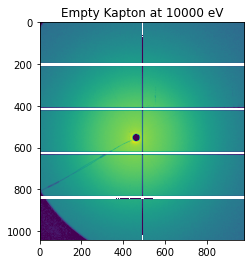

In [6]:
fig, ax = plt.subplots()
plotTitle_str = str(name)+' at '+str(round(energy))+' eV'
plt.title(plotTitle_str, fontdict=None, loc='center', pad=None)
ax.imshow(image_Ref, norm=LogNorm())

In [20]:
outputFrame

,Time,VacSampleX,VacSampleY,Energy,Pilatus_Tiff,Pilatus_Trigger,Pilatus_filename,PilatusAcqTime,Keysight1,Keysight2,...,x_Center,y_Center,SampleToDet_Distance,BackGround_SubtractionFactor,AbsCalibrationFactor,BackGrTransm,ReferenceTransm,SampleName_Reduction,Transm,TransmDev
0,34.827,133.00,-1.100000e-05,7000.002692,378,379,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,2.299318e-06,5.430643e-10,...,456.736,556.579,0.80169,1.0,1.367161e-09,1.000000,0.935973,Empty,1.000000,0.002323
1,639.834,123.00,-4.000000e-06,7000.002692,379,380,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,2.152853e-06,5.432002e-10,...,456.736,556.579,0.80169,1.0,1.367161e-09,1.000000,0.935973,GC,0.935973,0.002371
2,944.835,113.00,4.163336e-17,7000.002692,380,381,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,10,1.337529e-06,5.675809e-10,...,456.736,556.579,0.80169,1.0,1.367161e-09,1.000000,0.935973,AgBeh,0.582236,0.000241
3,963.534,88.16,1.000000e-06,7000.002692,381,382,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,1.448823e-06,5.820030e-10,...,456.736,556.579,0.80169,1.0,1.367161e-09,1.000000,0.935973,Empty Cap,0.633367,0.006531
4,1567.693,83.10,4.163336e-17,7000.002692,382,383,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,9.860936e-07,5.657099e-10,...,456.736,556.579,0.80169,1.0,1.367161e-09,1.000000,0.935973,Hexane Cap,0.433823,0.001418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5776.361,23.00,9.999880e-01,9999.991504,517,518,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,4.484193e-07,5.893668e-10,...,456.736,556.579,0.80169,0.8,6.964431e-10,0.854831,0.977500,217,0.847862,0.002237
140,6081.651,23.00,-9.149983e+00,9999.991504,518,519,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,4.445866e-07,6.032399e-10,...,456.736,556.579,0.80169,0.8,6.964431e-10,0.854831,0.977500,195,0.841095,0.001986
141,6390.580,13.00,7.799996e+00,9999.991504,519,520,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,4.389022e-07,6.102984e-10,...,456.736,556.579,0.80169,0.8,6.964431e-10,0.854831,0.977500,232,0.830432,0.002121
142,6994.894,13.00,5.880000e-04,9999.991504,520,521,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,4.517064e-07,5.958377e-10,...,456.736,556.579,0.80169,1.0,6.964431e-10,1.000000,0.977500,empty Kapton Hexane,0.854831,0.002255


In [9]:
image_object.data = image
save_image_name = pathSave_to2D+os.sep+str(name)+'_'+str(round(energy))+'_eV_Tif_'+str(tifNum)+'.edf'
image_object.write(save_image_name)

In [10]:
# usage of integrate 1d method
bin_number = 400 #how many data points are generated
q, I, e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)

In [9]:
if write_the_images == True: 
    print('export it')
else:
    pass

do nothing


In [12]:
int_Reference0 = integrate.trapz(y=ref0_I ,x=ref0_q, axis=- 1)
int_Reference = integrate.trapz(y=ref_I ,x=ref_q, axis=- 1)
calibrationFactor = int_Reference0/int_Reference
print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)

known 52.378257395 experimental 9.66733614074645 factor 5.418065186978766


[]

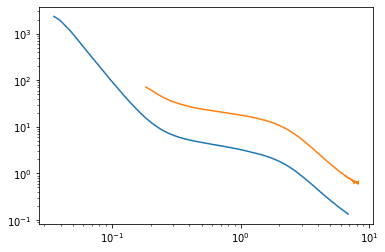

In [13]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.plot(ref_q, ref_I*calibrationFactor)
ax.loglog()

In [14]:
# find integration limits for the Reference data
q_Limit_min = np.array((ref0_q.min(),ref_q.min())).max()
q_Limit_max = np.array((ref0_q.max(),ref_q.max())).min()
q_normLimit_min = 2 * q_Limit_min
q_normLimit_max = q_Limit_max - 0.8*q_Limit_max
# find the index close to the limit
ref0_IndexMin = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_min))
ref0_IndexMax = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_max))
ref_IndexMin = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_min))
ref_IndexMax = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_max))

print('Normalization between:',q_normLimit_min,'nm^-1 and ',q_normLimit_max,'nm^-1')
print('Index for Reference file:',ref0_IndexMin,'with',ref0_q[ref0_IndexMin],'nm^-1 to',ref0_IndexMax,'with',ref0_q[ref0_IndexMax],'nm^-1')
print('Index for Experimental data:',ref_IndexMin,'with',ref_q[ref_IndexMin],'nm^-1 to',ref_IndexMax,'with',ref_q[ref_IndexMax],'nm^-1')

Normalization between: 0.3683394534903624 nm^-1 and  1.3693399999999993 nm^-1
Index for Reference file: 86 with 0.36699 nm^-1 to 271 with 1.3693 nm^-1
Index for Experimental data: 9 with 0.36544773030230315 nm^-1 to 59 with 1.372547750064092 nm^-1


In [16]:
type(q)

numpy.ndarray

In [4]:
inputFrame

,Time,VacSampleX,VacSampleY,Energy,Pilatus_Tiff,Pilatus_Trigger,Pilatus_filename,PilatusAcqTime,Keysight1,Keysight2,...,SampleName,SampleThickness,Empty_Index,Background_Index,Reference_Index,MaskFile,x_Center,y_Center,SampleToDet_Distance,BackGround_SubtractionFactor
0,34.827,133.00,-1.100000e-05,7000.002692,378,379,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,2.299318e-06,5.430643e-10,...,Empty,1.000000,0,0,1,mask_short2.edf,456.736,556.579,0.80169,1.0
1,639.834,123.00,-4.000000e-06,7000.002692,379,380,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,2.152853e-06,5.432002e-10,...,GC,0.005400,0,0,1,mask_short2.edf,456.736,556.579,0.80169,1.0
2,944.835,113.00,4.163336e-17,7000.002692,380,381,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,10,1.337529e-06,5.675809e-10,...,AgBeh,0.020000,0,0,1,mask_short2.edf,456.736,556.579,0.80169,1.0
3,963.534,88.16,1.000000e-06,7000.002692,381,382,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,1.448823e-06,5.820030e-10,...,Empty Cap,0.106904,0,0,1,mask_short2.edf,456.736,556.579,0.80169,1.0
4,1567.693,83.10,4.163336e-17,7000.002692,382,383,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,9.860936e-07,5.657099e-10,...,Hexane Cap,0.096177,0,0,1,mask_short2.edf,456.736,556.579,0.80169,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5776.361,23.00,9.999880e-01,9999.991504,517,518,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,4.484193e-07,5.893668e-10,...,217,0.100000,126,142,127,mask_short2.edf,456.736,556.579,0.80169,0.8
140,6081.651,23.00,-9.149983e+00,9999.991504,518,519,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,300,4.445866e-07,6.032399e-10,...,195,0.100000,126,142,127,mask_short2.edf,456.736,556.579,0.80169,0.8
141,6390.580,13.00,7.799996e+00,9999.991504,519,520,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,4.389022e-07,6.102984e-10,...,232,0.100000,126,142,127,mask_short2.edf,456.736,556.579,0.80169,0.8
142,6994.894,13.00,5.880000e-04,9999.991504,520,521,/messung/kmc/daten/2020/20_kw29tg14/pilatus_20...,600,4.517064e-07,5.958377e-10,...,empty Kapton Hexane,0.100000,126,126,127,mask_short2.edf,456.736,556.579,0.80169,1.0


In [18]:
metaFrame['Empty_Index'][2]

0